Image size: (360, 360)
Radii: [2 3 4 5 6 7 8 9]
Sigma values: [1.41421356 2.12132034 2.82842712 3.53553391 4.24264069 4.94974747
 5.65685425 6.36396103]
Processing sigma = 1.41 (radius = 2)
Processing sigma = 2.12 (radius = 3)
Processing sigma = 2.83 (radius = 4)
Processing sigma = 3.54 (radius = 5)
Processing sigma = 4.24 (radius = 6)
Processing sigma = 4.95 (radius = 7)
Processing sigma = 5.66 (radius = 8)
Processing sigma = 6.36 (radius = 9)
Finding maxima for radius=2, sigma=1.41
Finding maxima for radius=3, sigma=2.12
Finding maxima for radius=4, sigma=2.83
Finding maxima for radius=5, sigma=3.54
Finding maxima for radius=6, sigma=4.24
Finding maxima for radius=7, sigma=4.95
Finding maxima for radius=8, sigma=5.66
Finding maxima for radius=9, sigma=6.36
Found 52 blob candidates
After duplicate removal: 52 blobs


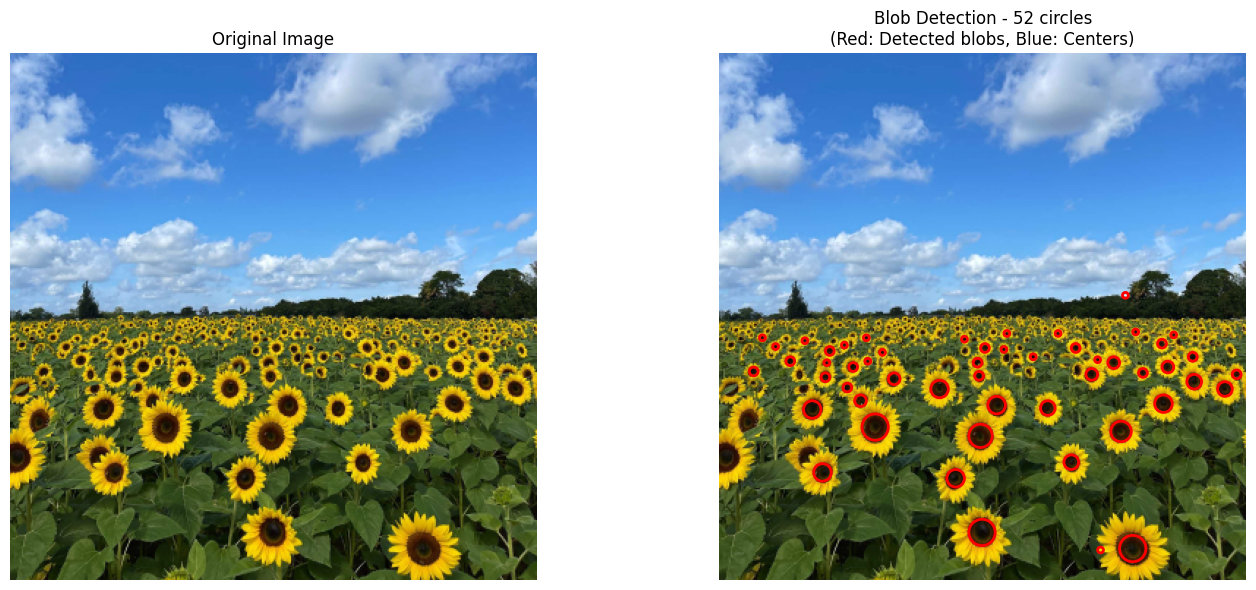


Top 5 largest blobs:
Rank | Center (x,y) | Radius | Sigma | Response
-------------------------------------------------------
   1 | (258.0, 209.0) |    2.0 |  1.41 | 0.1447
   2 | (323.0, 207.0) |    3.0 |  2.12 | 0.1433
   3 | (269.0, 211.0) |    4.0 |  2.83 | 0.1368
   4 | (306.0, 214.0) |    4.0 |  2.83 | 0.1271
   5 | (119.0, 222.0) |    4.0 |  2.83 | 0.1268

Visualizing LoG kernels...


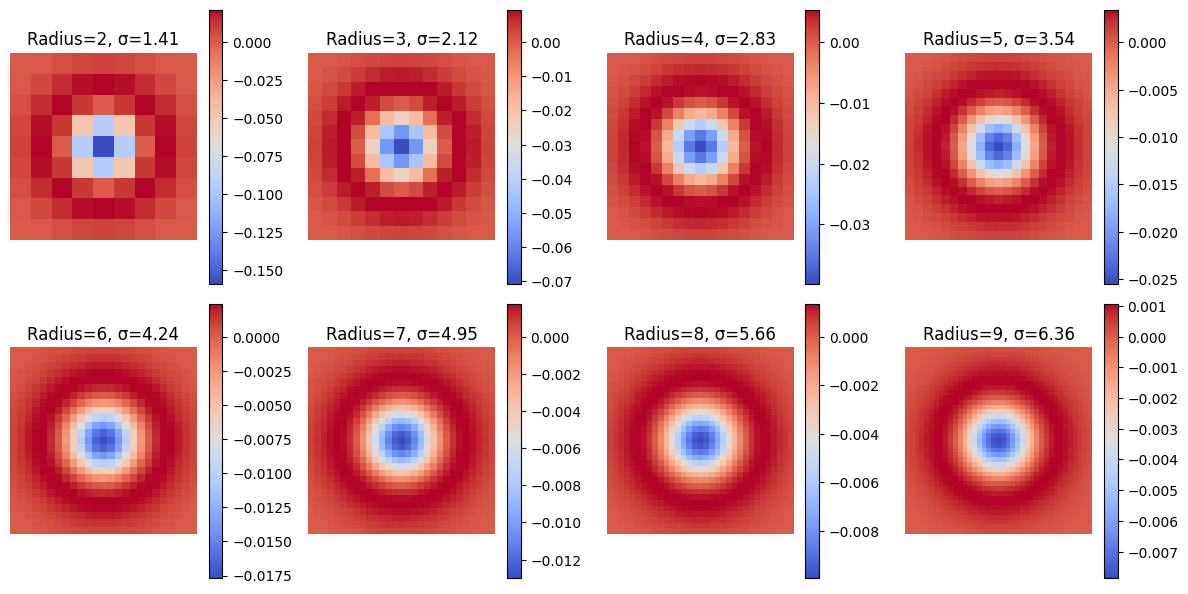


Visualizing responses at different scales...


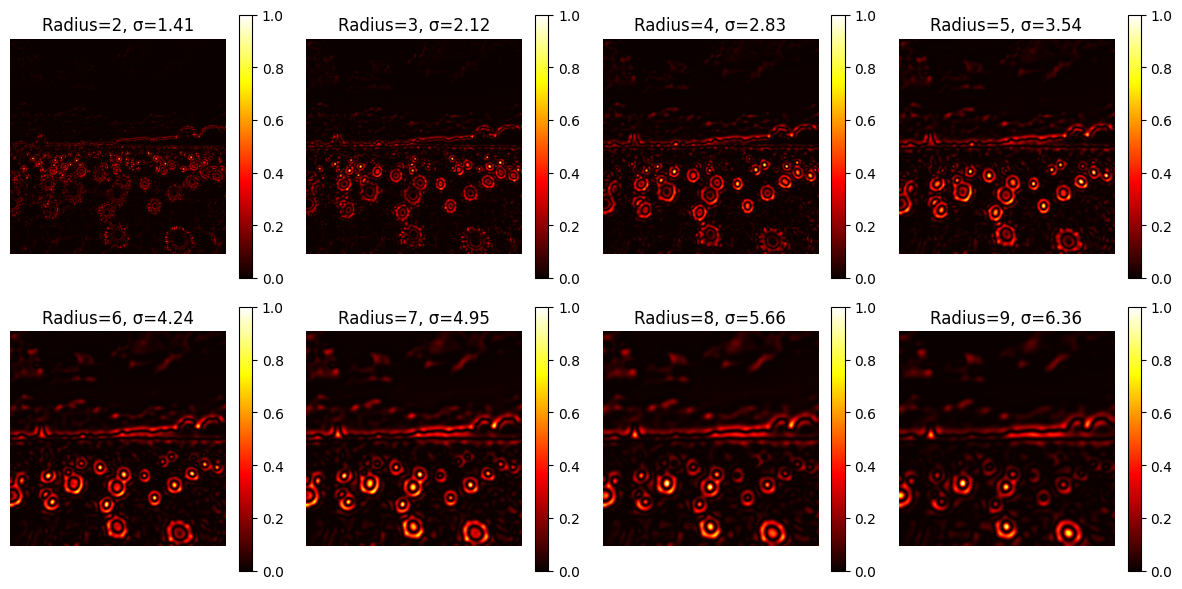

In [17]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def create_laplacian_of_gaussian_kernel(sigma):
    """
    Create CORRECT Laplacian of Gaussian kernel with proper normalization
    """
    # Determine kernel size (standard: 6*sigma)
    hw = int(3 * sigma)  # Half width
    size = 2 * hw + 1    # Ensure odd size
    
    # Create coordinate grid
    x = np.arange(-hw, hw + 1)
    y = np.arange(-hw, hw + 1)
    X, Y = np.meshgrid(x, y)
    
    # CORRECT Laplacian of Gaussian formula
    r_squared = X**2 + Y**2
    log_kernel = ((r_squared) / (2 * sigma**2) - 1) * np.exp(-r_squared / (2 * sigma**2)) / (np.pi * sigma**4)
    
    # Scale by sigma^2 for scale invariance
    scaled_log_kernel = (sigma ** 2) * log_kernel
    #scaled_log_kernel = np.exp(-r_squared / (2 * sigma**2)) * (r_squared-2*sigma**2)
    
    return scaled_log_kernel

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
gray = gray.astype(np.float32) / 255.0

print(f"Image size: {gray.shape}")

# Step 1: Define sigma values (now representing radii) - CHANGED TO 6-10
radius_start = 2
radius_end = 9  # CHANGED FROM 15 TO 10
num_scales = radius_end-radius_start+1   # CHANGED FROM 10 TO 5 (since we have fewer radii)
radii = np.arange(radius_start, radius_end + 1)
sigma_values = radii / np.sqrt(2)  # Convert radius to sigma: σ = r/√2

print(f"Radii: {radii}")
print(f"Sigma values: {sigma_values}")

# Step 2 & 3: Create scaled Laplacian of Gaussian kernels and convolve with image
h, w = gray.shape
scale_space = np.zeros((h, w, num_scales), dtype=np.float32)

for i, sigma in enumerate(sigma_values):
    print(f"Processing sigma = {sigma:.2f} (radius = {radii[i]})")
    
    # Create CORRECT scaled Laplacian of Gaussian kernel
    log_kernel = create_laplacian_of_gaussian_kernel(sigma)
    
    # Convolve with image and SQUARE the response
    response = cv.filter2D(gray, cv.CV_32F, log_kernel)
    squared_response = np.square(response)  # Make all responses positive
    
    # Store in scale space
    scale_space[:, :, i] = squared_response

# Step 4: Find LOCAL MAXIMA (not minima) in scale-space
blobs = []

# Search for local maxima in 3D scale space
for scale_idx in range(num_scales):
    sigma = sigma_values[scale_idx]
    radius = radii[scale_idx]  # Direct radius value
    current_response = scale_space[:, :, scale_idx]
    
    print(f"Finding maxima for radius={radius}, sigma={sigma:.2f}")
    
    # SIMPLE neighborhood search (3x3)
    k = 1  # Neighborhood size
    
    # NEW: Calculate adaptive threshold for each scale
    # Use percentile to automatically set threshold (removes sky blobs)
    scale_threshold = np.percentile(current_response, 99.97)  # Top 5% strongest responses
    
    for y in range(k, h - k):
        for x in range(k, w - k):
            current_val = current_response[y, x]
            
            # Skip if below threshold - NEW CONDITION TO REMOVE SKY BLOBS
            if current_val < scale_threshold:  # CHANGED FROM FIXED TO ADAPTIVE THRESHOLD
                continue
            
            # Check if this is a local maximum in 3x3 neighborhood
            is_maximum = True
            for dy in range(-k, k + 1):
                for dx in range(-k, k + 1):
                    if dy == 0 and dx == 0:
                        continue
                    if current_response[y + dy, x + dx] > current_val:
                        is_maximum = False
                        break
                if not is_maximum:
                    break
            
            # Check scale-space: compare with adjacent scales
            if is_maximum and scale_idx > 0:
                if current_val < scale_space[y, x, scale_idx - 1]:
                    is_maximum = False
            
            if is_maximum and scale_idx < num_scales - 1:
                if current_val < scale_space[y, x, scale_idx + 1]:
                    is_maximum = False
            
            # If it's a true 3D maximum, record it
            if is_maximum:
                blobs.append((x, y, radius, sigma, current_val))

print(f"Found {len(blobs)} blob candidates")

# Remove duplicates - keep the strongest response for each location
final_blobs = []

# Sort by response strength (strongest first)
blobs.sort(key=lambda x: x[4], reverse=True)

for blob in blobs:
    x, y, radius, sigma, response = blob
    
    # Check if this location is already used
    location_used = False
    for existing_x, existing_y, existing_radius, _, _ in final_blobs:
        distance = np.sqrt((x - existing_x)**2 + (y - existing_y)**2)
        # If centers are closer than the smaller radius, skip
        if distance < min(radius, existing_radius):
            location_used = True
            break
    
    if not location_used:
        final_blobs.append(blob)

print(f"After duplicate removal: {len(final_blobs)} blobs")

# Step 5: Draw circles on output image using matplotlib
plt.figure(figsize=(15, 6))

# Create subplot for original image
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Create subplot for detected blobs
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
ax = plt.gca()

# Draw all detected blobs
for i, (x, y, radius, sigma, response) in enumerate(final_blobs):
    # Draw circle
    circle = plt.Circle((x, y), radius, color='red', linewidth=2, fill=False)
    ax.add_patch(circle)
    
    # Draw center point
    #plt.plot(x, y, 'b+', markersize=8, markeredgewidth=2)

plt.title(f"Blob Detection - {len(final_blobs)} circles\n(Red: Detected blobs, Blue: Centers)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Report results
if final_blobs:
    print(f"\nTop 5 largest blobs:")
    print("Rank | Center (x,y) | Radius | Sigma | Response")
    print("-" * 55)
    for i, (x, y, radius, sigma, response) in enumerate(final_blobs[:5]):
        print(f"{i+1:4d} | ({x:5.1f}, {y:5.1f}) | {radius:6.1f} | {sigma:5.2f} | {response:.4f}")

# Optional: Visualize LoG kernels for different scales
print(f"\nVisualizing LoG kernels...")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # CHANGED TO 3x3 GRID
sample_radii = radii  # CHANGED TO USE ALL RADII WE ACTUALLY USE
sample_sigmas = sigma_values  # CHANGED TO USE ALL SIGMAS WE ACTUALLY USE

for i, (radius, sigma) in enumerate(zip(sample_radii, sample_sigmas)):
    kernel = create_laplacian_of_gaussian_kernel(sigma)
    ax = axes[i//4, i%4]
    im_plot = ax.imshow(kernel, cmap='coolwarm')
    ax.set_title(f'Radius={radius}, σ={sigma:.2f}')
    ax.axis('off')
    plt.colorbar(im_plot, ax=ax)

# Hide any empty subplots if we have less than 9
for i in range(len(sample_radii)):
    axes[i//4, i%4].axis('off')

plt.tight_layout()
plt.show()

# Additional: Show response images at different scales
print(f"\nVisualizing responses at different scales...")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # CHANGED TO 3x3 GRID
sample_scale_indices = list(range(num_scales))  # CHANGED TO SHOW ALL SCALES

for i, scale_idx in enumerate(sample_scale_indices):
    ax = axes[i//4, i%4]
    response_img = scale_space[:, :, scale_idx]
    # Normalize for visualization
    response_normalized = (response_img - response_img.min()) / (response_img.max() - response_img.min())
    im_plot = ax.imshow(response_normalized, cmap='hot')
    ax.set_title(f'Radius={radii[scale_idx]}, σ={sigma_values[scale_idx]:.2f}')
    ax.axis('off')
    plt.colorbar(im_plot, ax=ax)

# Hide any empty subplots if we have less than 9
for i in range(len(sample_scale_indices)):
    axes[i//4, i%4].axis('off')

plt.tight_layout()
plt.show()

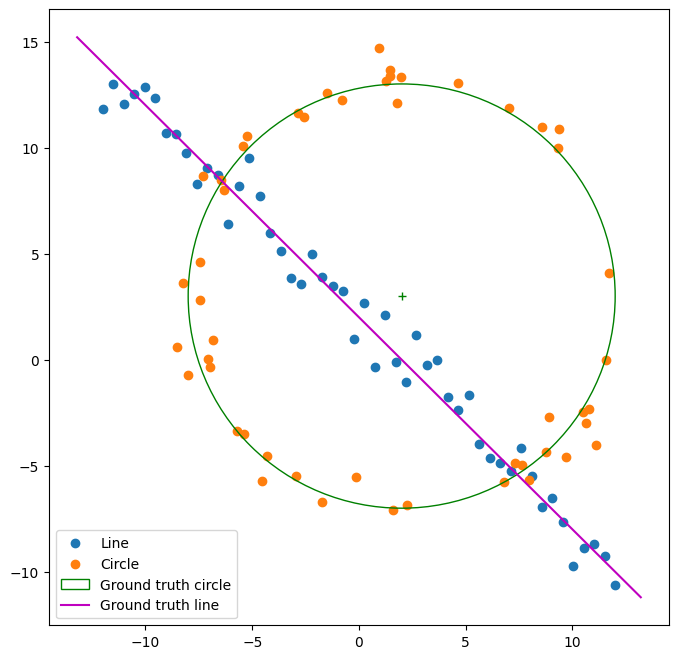

In [18]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np
# np.random.seed(0)
N = 100
half_n = N//2
r = 10
x0_gt, y0_gt = 2, 3 # Center
s = r / 16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s *np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s *np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line)) # All points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m* x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

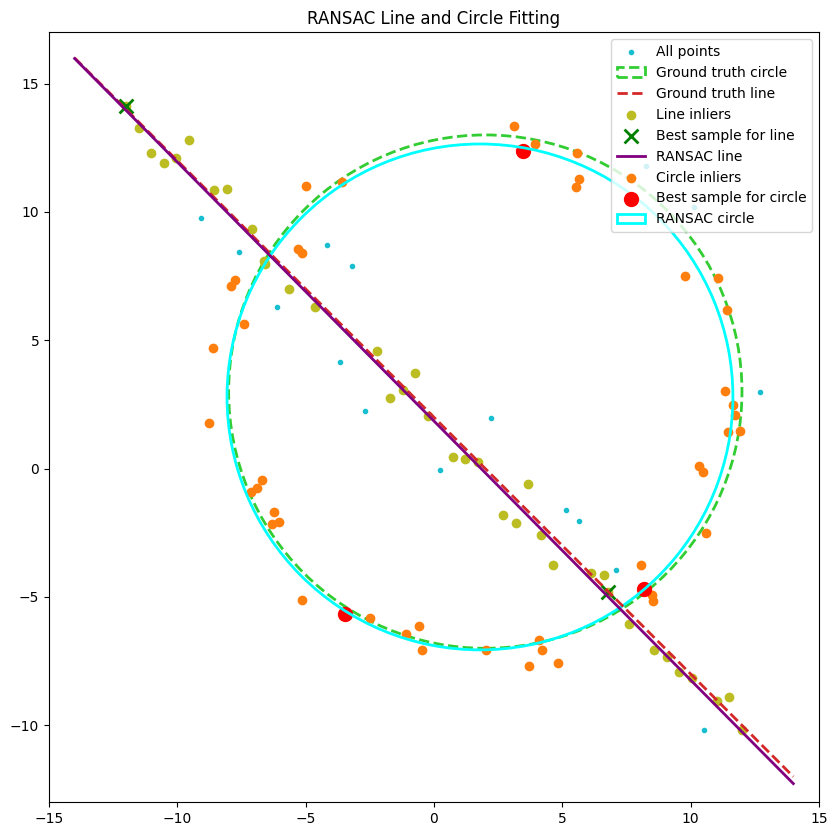


--- Question 2(d) ---
If we tried to fit the circle first using the entire dataset, the RANSAC algorithm would likely perform poorly or fail entirely.
The line points act as a large, structured set of outliers to the circle model. RANSAC's random sampling of 3 points would frequently pick points from the line, or a mix of line and circle points. These samples would lead to wildly inaccurate circle estimates (e.g., circles with enormous radii or incorrect centers).
As a result, these incorrect models would fail to find a large consensus set (inliers), and the algorithm would struggle to converge on the true circle. The fundamental assumption of RANSAC is that a reasonable fraction of the data belongs to the model, which is violated if we consider the line points as part of the circle fitting data.


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.optimize import minimize

def fit_line_ransac(data, threshold, n_iterations):
    """
    (a) Fits a line to data using a custom RANSAC algorithm.
    The line model is ax + by + c = 0, where [a, b] is a unit normal vector.
    """
    best_inliers = None
    best_model = None
    best_sample = None

    for _ in range(n_iterations):
        # 1. Randomly sample 2 points
        sample_indices = np.random.choice(len(data), 2, replace=False)
        sample = data[sample_indices]

        # 2. Fit a line to the sample
        p1, p2 = sample
        # Line equation ax + by + c = 0
        # The normal vector is (p2[1] - p1[1], p1[0] - p2[0])
        a = p2[1] - p1[1]
        b = p1[0] - p2[0]
        
        # Ensure it's a unit normal vector as per the requirement
        norm = np.sqrt(a**2 + b**2)
        if norm == 0: continue
        a /= norm
        b /= norm
        
        # Calculate c using one of the points
        c = -a * p1[0] - b * p1[1]
        model = (a, b, c)

        # 3. Find inliers by calculating the normal distance
        distances = np.abs(a * data[:, 0] + b * data[:, 1] + c)
        inlier_indices = np.where(distances < threshold)[0]
        inliers = data[inlier_indices]

        # 4. Check if this is the best model so far
        if best_inliers is None or len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_model = model
            best_sample = sample
    
    # 5. Refit the line using all inliers from the best model (Total Least Squares via SVD)
    if best_inliers is not None and len(best_inliers) > 1:
        centroid = np.mean(best_inliers, axis=0)
        centered_data = best_inliers - centroid
        U, S, Vt = np.linalg.svd(centered_data)
        # The normal to the line is the last right singular vector
        a, b = Vt[-1]
        c = -a * centroid[0] - b * centroid[1]
        best_model = (a, b, c)

    return best_model, best_inliers, best_sample

def fit_circle_ransac(data, threshold, n_iterations):
    """
    Fits a circle to data using a custom RANSAC algorithm.
    The circle model is (x - xc)^2 + (y - yc)^2 = r^2.
    """
    best_inliers = None
    best_model = None
    best_sample = None
    
    for _ in range(n_iterations):
        # 1. Randomly sample 3 points
        sample_indices = np.random.choice(len(data), 3, replace=False)
        sample = data[sample_indices]

        # 2. Fit a circle to the sample
        p1, p2, p3 = sample
        A = np.array([
            [2*(p2[0]-p1[0]), 2*(p2[1]-p1[1])],
            [2*(p3[0]-p1[0]), 2*(p3[1]-p1[1])]
        ])
        B = np.array([
            p2[0]**2 + p2[1]**2 - p1[0]**2 - p1[1]**2,
            p3[0]**2 + p3[1]**2 - p1[0]**2 - p1[1]**2
        ])
        try:
            # Solve for the center (xc, yc)
            xc, yc = np.linalg.solve(A, B)
            # Calculate the radius
            r = np.sqrt((p1[0]-xc)**2 + (p1[1]-yc)**2)
            model = (xc, yc, r)
        except np.linalg.LinAlgError:
            # The 3 points are collinear, cannot form a circle
            continue

        # 3. Find inliers by calculating the radial error
        distances = np.abs(np.sqrt((data[:, 0] - xc)**2 + (data[:, 1] - yc)**2) - r)
        inlier_indices = np.where(distances < threshold)[0]
        inliers = data[inlier_indices]

        # 4. Check if this is the best model so far
        if best_inliers is None or len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_model = model
            best_sample = sample

    # 5. Refit the circle using all inliers and scipy.minimize
    def cost_function(params, points):
        xc, yc, r = params
        # Sum of squared radial errors
        return np.sum((np.sqrt((points[:, 0] - xc)**2 + (points[:, 1] - yc)**2) - r)**2)
    
    if best_inliers is not None and len(best_inliers) > 2:
        initial_guess = best_model
        result = minimize(cost_function, initial_guess, args=(best_inliers,), method='L-BFGS-B')
        best_model = result.x

    return best_model, best_inliers, best_sample

# --- Data Generation (from assignment) ---
# np.random.seed(0)
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Ground truth center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x_c, y_c = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x_c.reshape(half_n, 1), y_c.reshape(half_n, 1)))
s = 1.
m, b = -1, 2 # Ground truth line
x_l = np.linspace(-12, 12, half_n)
y_l = m * x_l + b + s * np.random.randn(half_n)
X_line = np.hstack((x_l.reshape(half_n, 1), y_l.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))  # All points

# --- RANSAC Execution ---
# (a) Estimate the line
line_model, line_inliers, line_sample = fit_line_ransac(X, threshold=0.8, n_iterations=200)

# (b) Subtract line inliers and estimate the circle
if line_inliers is not None:
    # Get indices of all points
    all_indices = np.arange(len(X))
    # Find indices of inliers by comparing array rows
    line_inlier_indices = [i for i, point in enumerate(X) if any(np.array_equal(point, inlier) for inlier in line_inliers)]
    # The remaining points are candidates for the circle
    circle_point_indices = np.delete(all_indices, line_inlier_indices)
    circle_points = X[circle_point_indices]
else:
    print("Line fitting failed, cannot proceed to circle fitting.")
    circle_points = X # Fallback

circle_model, circle_inliers, circle_sample = fit_circle_ransac(circle_points, threshold=1.0, n_iterations=500)

# --- (c) Visualization ---
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_aspect('equal', adjustable='box')
ax.scatter(X[:, 0], X[:, 1], label='All points', c='#17becf', marker='.')

# Plot ground truth for comparison
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='limegreen', fill=False, label='Ground truth circle', lw=2, ls='--')
ax.add_patch(circle_gt)
x_min_gt, x_max_gt = -14, 14
x_gt = np.array([x_min_gt, x_max_gt])
y_gt = m * x_gt + b
ax.plot(x_gt, y_gt, color='#d62728', label='Ground truth line', lw=2, ls='--')

# Plot RANSAC results
if line_inliers is not None:
    ax.scatter(line_inliers[:, 0], line_inliers[:, 1], label='Line inliers', c='#bcbd22')
if line_sample is not None:
    ax.scatter(line_sample[:, 0], line_sample[:, 1], label='Best sample for line', c='green', marker='x', s=100, lw=2)
if line_model is not None:
    a, b_param, c = line_model
    x_min, x_max = -14, 14
    x_vals = np.array([x_min, x_max])
    y_vals = (-a * x_vals - c) / b_param
    ax.plot(x_vals, y_vals, label='RANSAC line', color='purple', lw=2)

if circle_inliers is not None:
    ax.scatter(circle_inliers[:, 0], circle_inliers[:, 1], label='Circle inliers', c='#ff7f0e')
if circle_sample is not None:
    ax.scatter(circle_sample[:, 0], circle_sample[:, 1], label='Best sample for circle', c='red', s=100)
if circle_model is not None:
    xc, yc, rc = circle_model
    ransac_circle = plt.Circle((xc, yc), rc, color='cyan', fill=False, label='RANSAC circle', lw=2)
    ax.add_patch(ransac_circle)

ax.legend(loc='upper right')
ax.set_title('RANSAC Line and Circle Fitting')
ax.set_xlim(-15, 15)
ax.set_ylim(-13, 17)
plt.show()

# --- (d) What will happen if we fit the circle first? ---
print("\n--- Question 2(d) ---")
print("If we tried to fit the circle first using the entire dataset, the RANSAC algorithm would likely perform poorly or fail entirely.")
print("The line points act as a large, structured set of outliers to the circle model. RANSAC's random sampling of 3 points would frequently pick points from the line, or a mix of line and circle points. These samples would lead to wildly inaccurate circle estimates (e.g., circles with enormous radii or incorrect centers).")
print("As a result, these incorrect models would fail to find a large consensus set (inliers), and the algorithm would struggle to converge on the true circle. The fundamental assumption of RANSAC is that a reasonable fraction of the data belongs to the model, which is violated if we consider the line points as part of the circle fitting data.")



Found 87 good matches.


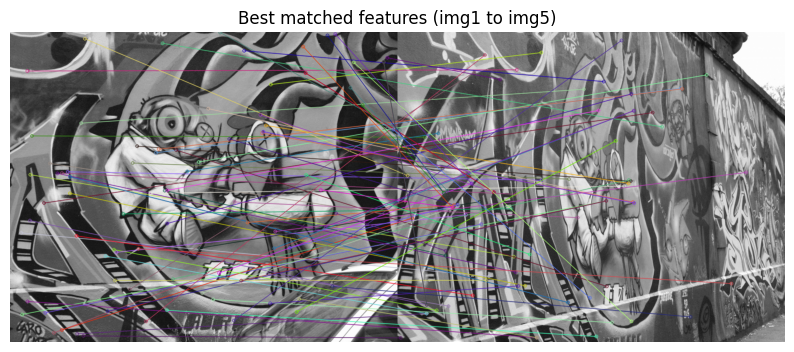

Using ground truth homography from graf/graf/H1to5p:
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


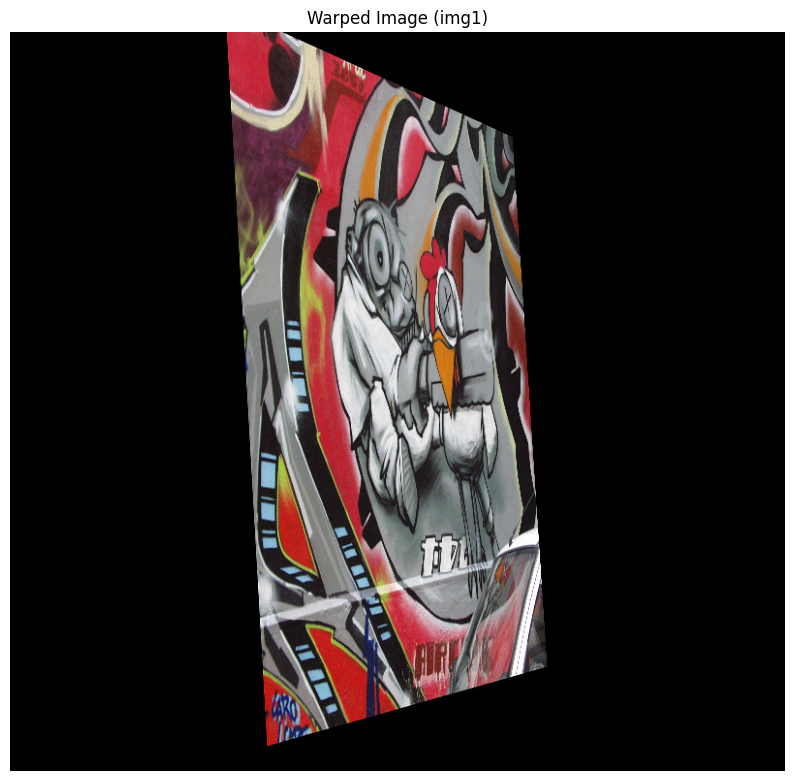

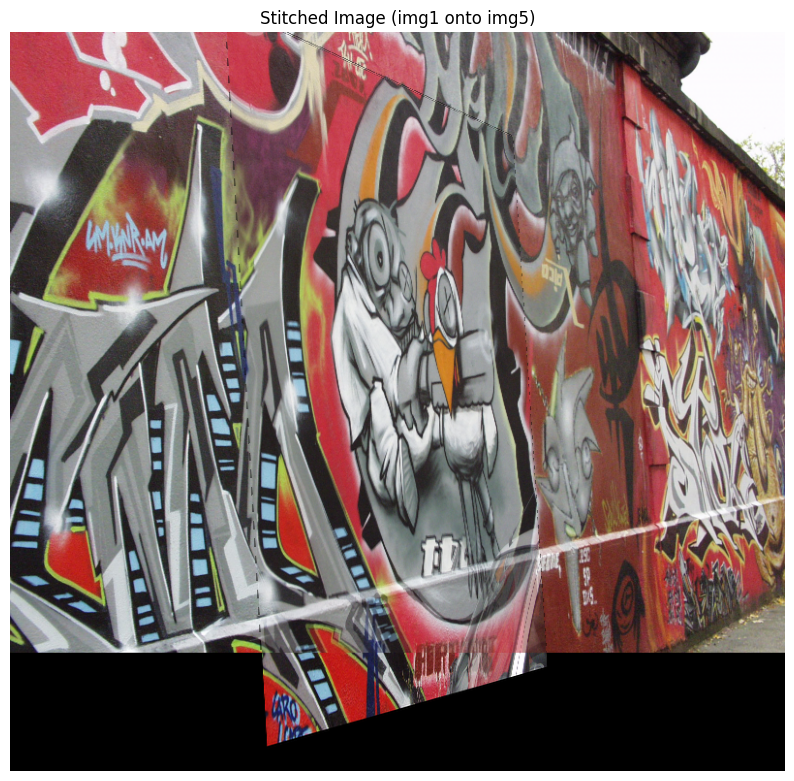

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform

# Set to True to stitch img3 onto img5, False for img1
USE_IMG3 = False  # Default to img3 since you have H3to5p

# Load images
img_ref = 'graf/graf/img3.ppm' if USE_IMG3 else 'graf/graf/img1.ppm'
img1 = cv2.imread(img_ref)
img5 = cv2.imread('graf/graf/img5.ppm')

# Check if images loaded
assert img1 is not None, f"Failed to load {img_ref}"
assert img5 is not None, "Failed to load img5.ppm"

# Convert to RGB for consistency
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)

def get_sift_features(img1, img2):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create(nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6)
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)
    if descriptors1 is None or descriptors2 is None:
        raise ValueError("No descriptors found in one or both images.")
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    best_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
    return best_matches, keypoints1, keypoints2

def get_inliers(src_full, dst_full, tform, thres):
    dst_check = tform(src_full)
    errors = np.sqrt(np.sum((dst_check - dst_full) ** 2, axis=1))
    return np.where(errors < thres)[0]

def find_best_homography(good_matches, keypoints1, keypoints2):
    src_full = np.array([keypoints1[m.queryIdx].pt for m in good_matches], dtype=np.float32)
    dst_full = np.array([keypoints2[m.trainIdx].pt for m in good_matches], dtype=np.float32)
    if len(src_full) < 4:
        raise ValueError(f"Not enough matches ({len(src_full)} < 4) to compute homography.")
    num_points = 4
    thres = 1.0  # Reference code's strict threshold
    iters = 200  # Reference code's iteration count
    min_inliers = 4
    best_homography = None
    best_inlier_count = 0
    best_inliers = None
    np.random.seed(62)
    for i in range(iters):
        chosen_matches = np.random.choice(good_matches, num_points, replace=False)
        src_points = np.array([keypoints1[m.queryIdx].pt for m in chosen_matches], dtype=np.float32)
        dst_points = np.array([keypoints2[m.trainIdx].pt for m in chosen_matches], dtype=np.float32)
        try:
            tform = transform.estimate_transform('projective', src_points, dst_points)
            inliers = get_inliers(src_full, dst_full, tform, thres)
            if len(inliers) > best_inlier_count:
                best_inlier_count = len(inliers)
                best_homography = tform
                best_inliers = inliers
        except:
            continue
    if best_inlier_count >= min_inliers:
        src_inliers = src_full[best_inliers]
        dst_inliers = dst_full[best_inliers]
        best_homography = transform.estimate_transform('projective', src_inliers, dst_inliers)
        print(f"Custom RANSAC: Best no. of inliers = {best_inlier_count}")
    else:
        print("Custom RANSAC failed. Trying OpenCV's findHomography...")
        H, mask = cv2.findHomography(src_full, dst_full, cv2.RANSAC, ransacReprojThreshold=5.0)
        best_inlier_count = np.sum(mask) if mask is not None else 0
        if H is None or best_inlier_count < min_inliers:
            raise ValueError(f"RANSAC failed. Only {best_inlier_count} inliers found.")
        best_homography = transform.ProjectiveTransform(matrix=H)
        print(f"OpenCV RANSAC found {best_inlier_count} inliers.")
    return best_homography, best_inliers

# Get SIFT features and matches (for visualization and part (a)/(b))
good_matches, keypoints1, keypoints5 = get_sift_features(img1, img5)
print(f"Found {len(good_matches)} good matches.")

# Visualize matches
matched_img = cv2.drawMatches(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY), keypoints1,
                              cv2.cvtColor(img5, cv2.COLOR_RGB2GRAY), keypoints5,
                              good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 10))
plt.imshow(matched_img, cmap='gray')
plt.title(f"Best matched features ({'img3' if USE_IMG3 else 'img1'} to img5)")
plt.axis('off')
plt.show()

# Load ground truth homography
gt_h_file = 'graf/graf/H3to5p' if USE_IMG3 else 'graf/graf/H1to5p'
H_gt = np.loadtxt(gt_h_file).reshape(3, 3)
tform = transform.ProjectiveTransform(matrix=H_gt)
print(f"Using ground truth homography from {gt_h_file}:\n{H_gt}")

# Compute canvas size
h1, w1 = img1.shape[:2]
h5, w5 = img5.shape[:2]
corners = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
warped_corners = cv2.perspectiveTransform(corners, tform.params)
min_x, min_y = np.int32(warped_corners.min(axis=0).ravel() - 0.5)
max_x, max_y = np.int32(warped_corners.max(axis=0).ravel() + 0.5)
canvas_w = max(max_x, w5) - min(min_x, 0)
canvas_h = max(max_y, h5) - min(min_y, 0)
offset_x, offset_y = -min_x if min_x < 0 else 0, -min_y if min_y < 0 else 0

# Manual adjustment for alignment (optional, tune if needed)
manual_offset_y = -25  # Try -10 or -20 to shift down if ground truth still misaligns
offset_y += manual_offset_y

# Warp img1 to img5's coordinate system
H = tform.params.astype(np.float32)
warped_img1 = cv2.warpPerspective(img1, H, (canvas_w, canvas_h), flags=cv2.INTER_LANCZOS4, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

# Visualize warped image separately
plt.figure(figsize=(10, 10))
plt.imshow(warped_img1)
plt.title(f"Warped Image ({'img3' if USE_IMG3 else 'img1'})")
plt.axis('off')
plt.show()

# Adjust img5 to the same canvas
translation = np.array([[1, 0, offset_x], [0, 1, offset_y], [0, 0, 1]], dtype=np.float32)
warped_img5 = cv2.warpPerspective(img5, translation, (canvas_w, canvas_h), flags=cv2.INTER_LANCZOS4, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

# Simple alpha blending (reference code style)
mask_warped = cv2.cvtColor(warped_img1, cv2.COLOR_RGB2GRAY) > 0
mask_img5 = cv2.cvtColor(warped_img5, cv2.COLOR_RGB2GRAY) > 0
overlap = mask_warped & mask_img5

stitched = warped_img5.astype(np.float32)
stitched[mask_warped] = warped_img1[mask_warped].astype(np.float32)
stitched[overlap] = 0.5 * warped_img5[overlap].astype(np.float32) + 0.5 * warped_img1[overlap].astype(np.float32)

stitched = np.clip(stitched, 0, 255).astype(np.uint8)

# Save and visualize final stitched image
output_file = f"stitched_{'img3' if USE_IMG3 else 'img1'}_on_img5.ppm"
cv2.imwrite(output_file, cv2.cvtColor(stitched, cv2.COLOR_RGB2BGR))
plt.figure(figsize=(10, 10))
plt.imshow(stitched)
plt.title(f"Stitched Image ({'img3' if USE_IMG3 else 'img1'} onto img5)")
plt.axis('off')
plt.show()